# Homework 2

### House Prices: Advanced Regression Techniques (Kaggle Competition)

#### By: Spencer Wise

If you ask a home buyer to describe their dream house, they'll probably list the number of bedrooms and bathrooms they're looking for and maybe an approximate size in square feet. They may even describe the style of home whether it be a cape cod style, modern, or ranch style. Do they how much each of these features contributes to the price of the home? Probably not, but that's exactly what we're going to try and figure out through machine learning!

The goal of this Kaggle competition and assignment is to create models that predict house prices. The training dataset contains 1460 observations and 80 features. The test dataset has 1459 observations and 79 features. To begin, let's start by importing the necessary packages and reading in the data.

### Module Imports

In [36]:
# Pandas for data loading, manipulation etc.
import pandas as pd

# Numeric functions
import numpy as np
from scipy import stats
from scipy.stats import norm

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Machine learning packages for modeling 
from sklearn.linear_model import SGDRegressor, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer, f1_score, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split, learning_curve, RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# Other Packages
import warnings
warnings.filterwarnings('ignore')
#import missingno as msno

### Load Data

Here we are going to first load the training and test datasets into pandas dataframes.

In [17]:
# Loading datasets into separate pandas dataframes
train = pd.read_csv(r"C:\Users\Spencer\Dropbox\School\Fall 2018\Machine Learning\Projects\Homework_2\train.csv", encoding="latin1")
test = pd.read_csv(r"C:\Users\Spencer\Dropbox\School\Fall 2018\Machine Learning\Projects\Homework_2\test.csv", encoding="latin1")

In [26]:
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


One interesting thing to note right off the bat is that the training dataset has one more column than the test dataset. that is because the train dataset includes our target value (aka SalePrice). Let's take a closer look by previewing our training data. 

In [18]:
# Preview the data
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Analyze the Target

The first thing that we want to do is identify and analyze the target. In this case, our target is "SalePrice" as it is the variable that we will be trying to predict. 

In [32]:
# Descriptive summary of SalePrice data
target = train['SalePrice']
target.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Next we will want to take a look at the distribution of the SalePrice data and a probability plot to test for normality.

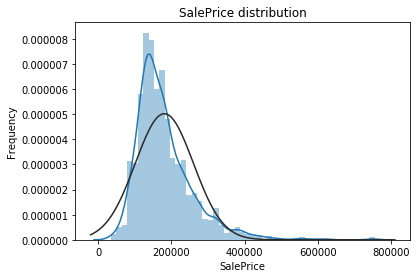

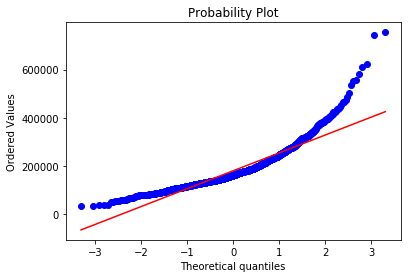

In [37]:
# Create a histogram and normal probablity plotof the SalePrice data
sns.distplot(target, fit=norm);
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
fig = plt.figure()
res = stats.probplot(target, plot=plt)

We can see from the above histogram that the target variable is not normal. It is right skewed and does not follow the diagonal line on the probability plot. Because we know that linear models prefer normally distributed data, we will apply a transformation to our target variable in order to make it more normally distributed. In cases of positive skewness, log transformations usually work well so we will perform a log-transformation of the target variable.

In [42]:
# Applying a log transformation of the SalePrice data
target = np.log(target)

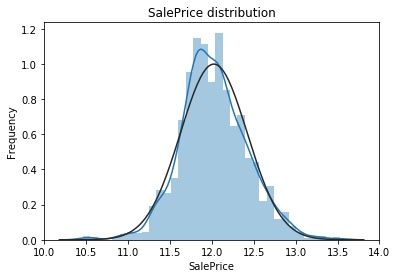

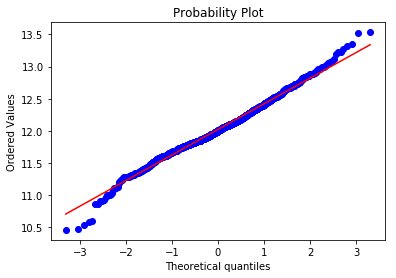

In [43]:
# Transformed histogram and normal probability plot
sns.distplot(target, fit=norm);
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
fig = plt.figure()
res = stats.probplot(target, plot=plt)

The skew now seems to be corrected and the data appears to be more normally distributed. 

### Learn the Data

Now that we've corrected our target variable, we'll want to learn as much as we can about the data. The things that we will focus on are:
- Knowing all the variables in the dataset
- Knowing what is correlated
- Knowing if there are missing variables 

In [46]:
# List all of the variables in the dataset
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

As we can see above, we have 80 variables in the dataset. 

Next we'll want to get an idea of any correlation in the data. The first way we will do this is by creating a heatmap of all of the numeric variables. 

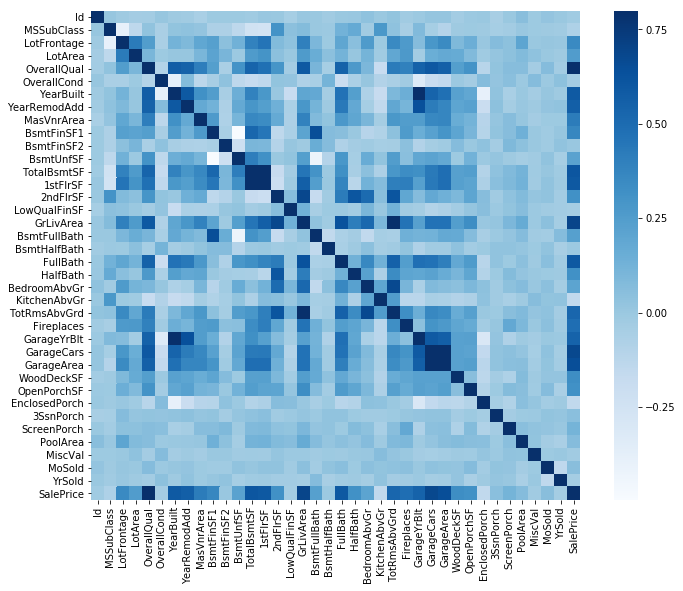

In [49]:
# Create a correlation matrix or heatmap
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, cmap="Blues");

The heatmap is a great way to quickly identify relationships between our variables. 

The first correlations that we will want to pay particular attention to are the 'SalePrice' correlations. 'OverallQal', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'GarageCars', and 'GarageArea' all are dark blue and appear to have highly positive correlation with 'SalePrice'.  

There are a few other dark blue squares that stand out for example 'GarageYrBlt' and 'YearBuilt' and 'TotalBsmtSF' and '1stFlrSF' which may represent multicollinearity. 

For now, we will focus on the 'SalePrice' correlations. Let's take a closer look at these correlations by creating a target correlations heatmap

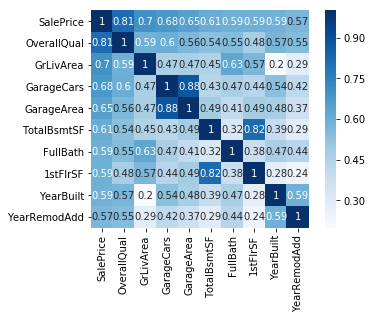

In [56]:
# Target variable heatmap
n = 10
cols = corrmat.nlargest(n, 'SalePrice')['SalePrice'].index
corrm = np.corrcoef(train[cols].values.T)
hm = sns.heatmap(corrm, cbar=True, annot=True, square=True, yticklabels=cols.values, xticklabels=cols.values, cmap="Blues")
plt.show()

Now we're zoomed in and able to look at the 10 variables most correlated with 'SalePrice'. Upon closer look a few of these variables appear to be very similar:

- GarageCars and GarageArea seem to be correlated about the same and I would assume that is because the number of cars that fit in a garage is also determined by the size of the garage area. They will essentially act as one. As a result, we'll only need one of these variables. We'll keep GarageCars as it is slightly higher. 
- TotalBsmtSF and 1stFlrSF also appear to be closely correlated (it makes sense in my head as the basement will most likely be the same size and shape as the floor above it for the most part). We'll keep TotalBsmtSF since it has the higher correlation.
- YearBuilt and YearRemodAdd also seem to have the same problem. Again we'll keep YearBuilt as it has a higher correlation.

Everything else seems to be ok so to summarize, the variables we believe to have the highest positive correlation with SalePrice (with the exception of some variables that suffer from multicollinearity) are:
- OverallQual
- GrLivArea
- GarageCars
- TotalBsmtSF
- FullBath
- YearBuilt


Now let's create some scatter plots between 'SalePrice' and these highly correlated variables.

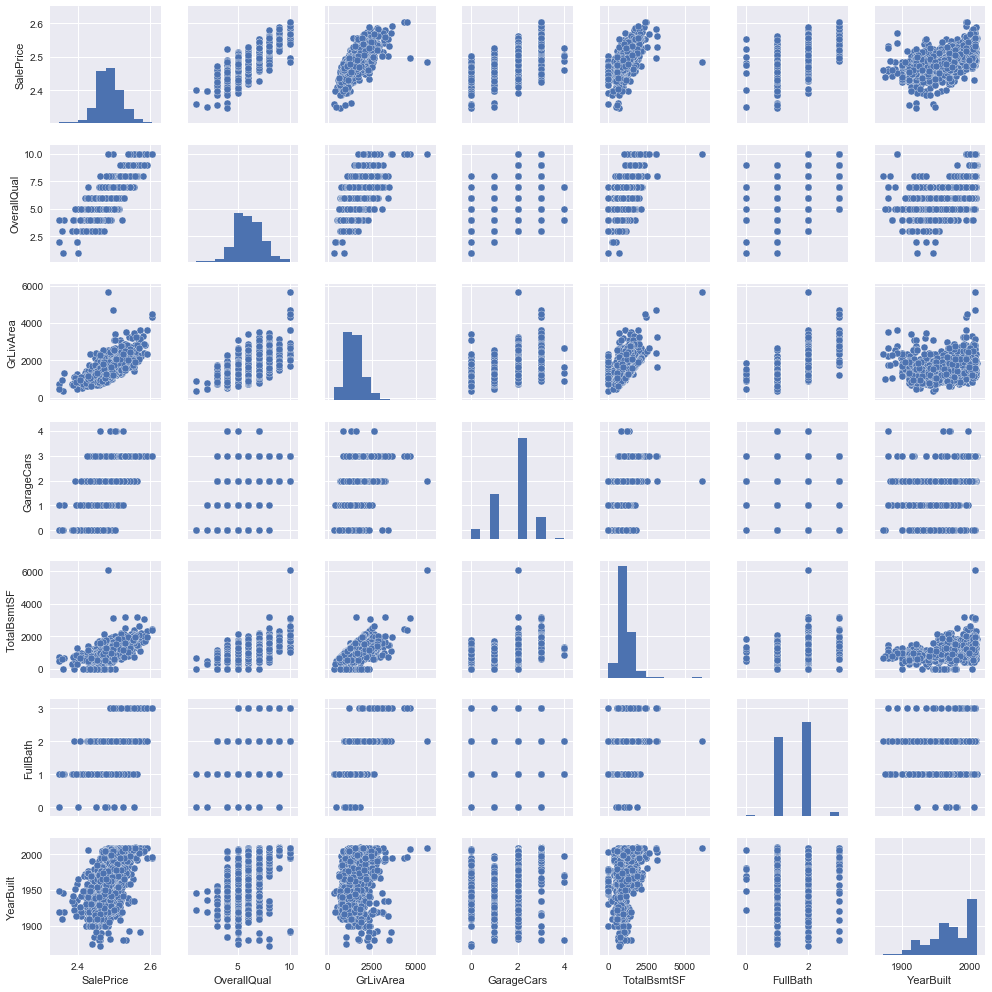

In [68]:
# Use pairplot to see the bivariate relationship between each pair of features
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size= 2, kind='scatter')
plt.show();

In the above scatterplots, we gain quite a bit of insight. Some of the highlights are the SalePrice / GrLivArea plot which shows a fairly linear relationship. We see a fairly similar shape when we look at the SalePrice / TotalBsmtSF graph as well, which is to be expected. OverallQual also shows a very strong correlation with an almost exponential shape. 

### Clean the Data

Now that we've learned more about our data, it is time to clean it. Our goal in cleaning the data is to apply the necessary transformations to our data before feeding it to our algorithm.

The steps we will take for data cleaning are:
- Detect and correct missing values
- Remove outliers

### Missing Data

We first want to figure out how much missing data we have, where they are located, and then determine whether they are missing randomly or non-randomly. 

This is important because we need to make sure that the missing data is not biased. The answer to this question is important because it will help us decide how to deal with the missing data. 

In [70]:
# Display columns with missing data (nan values)
cols_with_na = train.isnull().sum()
cols_with_na = cols_with_na[cols_with_na>0]
print(cols_with_na.sort_values(ascending=False))

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


Looking at the description above, we can determine that many of the Nan values are not true missing values, but rather an indication that the property does not have a specific feature. For example a property with a Nan in any of the Garage or Basement features has no garage or basement. 

This is valuable information as it absolutely affects the price of the home. The way I will correct this is by replacing the missing values with the string "None" for the categorical variables and with a zero for the numeric variables. 

In [71]:
# Columns where NaN values are important
cols_fillna = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2']

# Replace 'NaN' with 'None' in these columns
for col in cols_fillna:
    train[col].fillna('None',inplace=True)
    
# GarageYrBlt NaNs means no garage. We will fill with property YearBuilt instead as it is more accurate than 0
train.loc[train.GarageYrBlt.isnull(),'GarageYrBlt'] = train.loc[train.GarageYrBlt.isnull(),'YearBuilt']

# No masonry veneer. Replace with 0
train.MasVnrArea.fillna(0,inplace=True)

# No basement. Replace with 0  
train.BsmtFullBath.fillna(0,inplace=True)
train.BsmtHalfBath.fillna(0,inplace=True)
train.BsmtFinSF1.fillna(0,inplace=True)
train.BsmtFinSF2.fillna(0,inplace=True)
train.BsmtUnfSF.fillna(0,inplace=True)
train.TotalBsmtSF.fillna(0,inplace=True)

# No garage. Replace with 0
train.GarageArea.fillna(0,inplace=True)
train.GarageCars.fillna(0,inplace=True)

# Check to make sure we have successfully replaced our missing values
train[cols_fillna].head(5)

,PoolQC,MiscFeature,Alley,Fence,MasVnrType,FireplaceQu,GarageQual,GarageCond,GarageFinish,GarageType,BsmtExposure,BsmtCond,BsmtQual,BsmtFinType1,BsmtFinType2
0,None,None,None,None,BrkFace,None,TA,TA,RFn,Attchd,No,TA,Gd,GLQ,Unf
1,None,None,None,None,None,TA,TA,TA,RFn,Attchd,Gd,TA,Gd,ALQ,Unf
2,None,None,None,None,BrkFace,TA,TA,TA,RFn,Attchd,Mn,TA,Gd,GLQ,Unf
3,None,None,None,None,None,Gd,TA,TA,Unf,Detchd,No,Gd,TA,ALQ,Unf
4,None,None,None,None,BrkFace,TA,TA,TA,RFn,Attchd,Av,TA,Gd,GLQ,Unf


The next step is to deal with the missing LotFrontage values. It's missing a decent amount of values. Lot Frontage is the only remaining numeric variable with missing values. We'll fill them in with the mean lot frontage. 

In [72]:
# Replacing NaN LotFrontage values with mean value
train['LotFrontage'] = train['LotFrontage'].fillna(train['LotFrontage'].mean())

Now the remaining missing values are all found in categorical variables. To deal with these, we will replace them with the mode value. 

In [76]:
# Replacing NaN categorical variable values with the mode value
for variable in train:
   # Features with a 'dtype' of O are categorical 
    if train[variable].dtype == 'O':
       train[variable] = train[variable].fillna(train[variable].mode()[0])

Now let's double check to make sure we've corrected all of our missing values.

In [75]:
# Should return 'False' if we've corrected them all
train.isnull().any().any()

False

### Outliers

The next step on our journey to clean data is finding and removing any outliers.  To start, we'll separate our variables based on whether they are categorical or numerical. 

In [78]:
# Create two empty lists
numeric_variables = []
categorical_variables = []

# Seperate variables by dtype
for variable in train.columns:
    if train[variable].dtype == "object":
        categorical_variables.append(variable)
    else:
        numeric_variables.append(variable)
        
print("Number of Numerical Variables:", len(numeric_variables), "\nNumber of Categorical Variables:", len(categorical_variables))

Number of Numerical Variables: 38 
Number of Categorical Variables: 43


Now we will filter outliers by determining the z-score of each column relative to the column mean and standard deviation. Then we will remove rows that contain a numeric variable value greater than 5 standard deviations away from the standardized mean. 

In [80]:
n_std = 5
len(train) - len(train[train[numeric_variables].apply(lambda x: np.abs(x - x.mean()) / x.std() < n_std).all(axis=1)])

89

Using this rule, we will drop 89 rows of our training data. 

In [82]:
# Drop rows in training set (and target) according to the rule described above
train = train[train[numeric_variables].apply(lambda x: np.abs(x - x.mean()) / x.std() < 10).all(axis=1)]

Since we've dropped rows of data, we need to recreate our target array so as to not include those missing instances. 

In [95]:
target = train['SalePrice']
target = np.log(target)

### Dummy Variables

Now that we have removed all of our outliers, we will move onto the final step in the data cleaning process which is to create dummy variables for our categorical variables

In [83]:
train = pd.get_dummies(train)
print(train.shape)

(1437, 297)


### Clean Test Data

Now I will perform all  of the data cleaning on the test data as well.

In [84]:
# Columns where NaN values are important
cols_fillna = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2']

# Replace 'NaN' with 'None' in these columns
for col in cols_fillna:
    test[col].fillna('None',inplace=True)
    
# GarageYrBlt NaNs means no garage. We will fill with property YearBuilt instead as it is more accurate than 0
test.loc[test.GarageYrBlt.isnull(),'GarageYrBlt'] = test.loc[test.GarageYrBlt.isnull(),'YearBuilt']

# No masonry veneer. Replace with 0
test.MasVnrArea.fillna(0,inplace=True)

# No basement. Replace with 0  
test.BsmtFullBath.fillna(0,inplace=True)
test.BsmtHalfBath.fillna(0,inplace=True)
test.BsmtFinSF1.fillna(0,inplace=True)
test.BsmtFinSF2.fillna(0,inplace=True)
test.BsmtUnfSF.fillna(0,inplace=True)
test.TotalBsmtSF.fillna(0,inplace=True)

# No garage. Replace with 0
test.GarageArea.fillna(0,inplace=True)
test.GarageCars.fillna(0,inplace=True)

# Replacing NaN LotFrontage values with mean value
test['LotFrontage'] = test['LotFrontage'].fillna(test['LotFrontage'].mean())

# Replacing NaN categorical variable values with the mode value
for variable in test:
   # Features with a 'dtype' of O are categorical 
    if test[variable].dtype == 'O':
       test[variable] = test[variable].fillna(test[variable].mode()[0])
    
# Should return 'False' if we've corrected them all
test.isnull().any().any()

False

In [85]:
# Create Test Dummies
test = pd.get_dummies(test)
print(test.shape)

(1459, 285)


### Model Fitting & Evaluation

The first thing I will do is create a kind of baseline model from what we did in class. This will allow us to have something to compare our later more complicated models against.  

But first, time to scale the data!

In [86]:
# Scale the training dataset
scaler = StandardScaler()
scaler.fit(train)
scaled_train_df = scaler.transform(train)

# Scale the test dataset
scaler.fit(test)
scaled_test_df = scaler.transform(test)

#### Basic Linear Regression

In [107]:
# Fit the model
basic_linear_regression_model = SGDRegressor(tol=.00001, eta0=.01)
basic_linear_regression_model.fit(scaled_train_df, target)

# Calculate the MSE
predictions = basic_linear_regression_model.predict(scaled_train_df)
mse = mean_squared_error(target, predictions)
print("MSE: {}".format(np.sqrt(mse)))

MSE: 1.8025917999179029


Nice! We have our first model up and running! If we disect our model above, we will see that we passed a few parameters to SGDRegressor. These two parameters are telling it the initial learning rate and when we would like it to stop iterating. 

By simply adjusting these two parameters, we can significantly manipulate our MSE output.

### Implementing a Train/Test Split into the Basic Linear Regression

Our next addition to our model will be a train/test split. Above, we fit the model using all of the training data. But word on the street is that by splitting the data into a training set and a test set, we can improve our results!

In addition to improving our Mean Squared Error output, the train/test split should also help to avoid any over-fitting of our data.  

In [112]:
# Splitting the data into two datasets (training and test)
X_train, X_test, y_train, y_test = train_test_split(scaled_train_df, target, test_size=0.20, random_state=42)

Now we can use our training dataset to train and then calculate the MSE for both our training and testing data set. 

In [113]:
# Fit the model
linear_regression_model = SGDRegressor(tol=.00001, eta0=.01)
linear_regression_model.fit(X_train, y_train)

# Predit target values for the training and test datasets
train_predictions = linear_regression_model.predict(X_train)
test_predictions = linear_regression_model.predict(X_test)

# Calculate the MSE for the training and test datasets
train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

print("Train MSE: {}".format(train_mse))
print("Test MSE: {}".format(test_mse))

Train MSE: 1.8770767465226588
Test MSE: 0.19297505819113334


We now have our MSE for both our training and testing data. One thing we can notice right off the bat is that the gap between the two is relatively large. This could suggest an overfitting problem. 

Next we will add cross validation to our Basic Linear Regression Model to see if that will help us improve as well.

#### Adding Cross Validation to our Linear Regression Model

With cross validation, we further split our data into training sets and validation sets. This allows us to test a whole bunch of hyper parameters to see which ones perform the best on our training data. We then take the model that performs the best on the validation set and see how it does against the testing set. 

In [114]:
# Give a list of parameters for cross validation
param_dist = {"eta0": [ .001, .002, .01, .04, .1, .2, 1, 5], "tol": [.000001, .00001, .0001, .001, .01, .1]}
n_iter_search = 8

# Cross validation and fit the model
cross_linear_regression_model = SGDRegressor()
cross_random_search = RandomizedSearchCV(cross_linear_regression_model, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=3, scoring='neg_mean_squared_error')
cross_random_search.fit(X_train, y_train)

print("Best Parameters: {}".format(cross_random_search.best_params_))
print("Best Negative MSE: {}".format(cross_random_search.best_score_))

Best Parameters: {'tol': 0.001, 'eta0': 0.001}
Best Negative MSE: -0.08011371665776168


Our cross validation has done a whole lot for us here! First, it's telling us which parameters performed the best which were, in this case, a tolerance of 0.001 and a learning rate of 0.001. It has also improved our negative MSE and brought it down to -0.0801. This is great news, we're on the right track and moving in the right direction!

Now that we've implemented the train/test split and cross validation, let's try our hand at regularization.

### Regularized Linear Models

Regularization is a method that is used to penalize a model for learning complet relationship or form large coefficients. This is yet another way we can avoid the problem of over-fitting. 

There are three different regularized linear models we'll try to see which one performs the best. These three models are:
- Lasso: Modifies the cost function by adding the sum of the absolute values of the coefficients.
- Ridge: Modifies the cost function by adding the sum of the squared values of the coefficients.
- Elastic-Net: Add both and choose how to weight them. 

Each of these three regularization methods takes a weighting factor (alpha) that tells you how much you should weight the regularization term. An alpha of zero would add zero penalty. A high alpha would penalize the model significantly for ahving large coefficients. We will use cross validation to figure out the best alpha value. 

#### Lasso

In [121]:
# Cross Validation
lasso = linear_model.Lasso()
lasso_gridsearch = GridSearchCV(lasso, {"alpha": [.1, .3, .5, .7, .9]})
# Fit the Model
lasso_gridsearch.fit(X_train, y_train)
# Make Predictions
train_predictions = lasso_gridsearch.predict(X_train)
test_predictions = lasso_gridsearch.predict(X_test)
# Print the best parameters and the MSE
print("Lasso:")
print("Best Parameters: {}".format(lasso_gridsearch.best_params_))
print("Train MSE: {}".format(mean_squared_error(y_train, train_predictions)))
print("Test MSE: {}".format(mean_squared_error(y_test, test_predictions)))

Lasso:
Best Parameters: {'alpha': 0.1}
Train MSE: 0.0001813711715619114
Test MSE: 0.0001562111360021303


#### Ridge

In [125]:
# Cross Validation
ridge = linear_model.Ridge()
ridge_gridsearch = GridSearchCV(ridge, {"alpha": [.1, .3, .5, .7, .9]})
# Fit the Model
ridge_gridsearch.fit(X_train, y_train)
# Make Predictions
train_predictions = ridge_gridsearch.predict(X_train)
test_predictions = ridge_gridsearch.predict(X_test)
# Print the best parameters and the MSE
print("Ridge:")
print("Best Parameters: {}".format(ridge_gridsearch.best_params_))
print("Train MSE: {}".format(mean_squared_error(y_train, train_predictions)))
print("Test MSE: {}".format(mean_squared_error(y_test, test_predictions)))

Ridge:
Best Parameters: {'alpha': 0.1}
Train MSE: 6.009333992250589e-09
Test MSE: 1.1439053232384496e-08


#### Elastic Net

In [127]:
# The values for 'l1_ratio' were the values recommended in the scikit-learn docs
clf_en = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], alphas=[.1, 1, 10])
# Fit the Model
clf_en.fit(X_train, y_train)
# Make Predictions
train_predictions = clf_en.predict(X_train)
test_predictions = clf_en.predict(X_test)
# Print the best parameters and the MSE
print("Elastic Net:")
print("Train MSE: {}".format(mean_squared_error(y_train, train_predictions)))
print("Test MSE: {}".format(mean_squared_error(y_test, test_predictions)))

Elastic Net:
Train MSE: 0.00010298597041879826
Test MSE: 8.874881354294843e-05
